In [1]:
!pip install qiskit-addon-sqd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 3.5 MB/s eta 0:00:00


In [2]:
import sys
import shutil
import tarfile
from google.colab import drive
drive.mount('/content/gdrive')
shutil.copy('/content/gdrive/MyDrive/qcintro.tar.gz', '.')
with tarfile.open('qcintro.tar.gz', 'r:gz') as tar:
    tar.extractall(path='/root/.local')

sys.path.append('/root/.local/lib/python3.11/site-packages')

!git clone -b branch-2025 https://github.com/UTokyo-ICEPP/qc-workbook-lecturenotes
!cp -r qc-workbook-lecturenotes/qc_workbook /root/.local/lib/python3.11/site-packages/

Mounted at /content/gdrive
Cloning into 'qc-workbook-lecturenotes'...
remote: Enumerating objects: 1019, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 1019 (delta 47), reused 47 (delta 25), pack-reused 933 (from 1)
Receiving objects: 100% (1019/1019), 13.26 MiB | 17.30 MiB/s, done.
Resolving deltas: 100% (567/567), done.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from scipy.sparse import kron, identity
from scipy.sparse.linalg import eigsh

from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit_addon_sqd.subsampling import postselect_and_subsample, subsample
from qiskit_addon_sqd.counts import generate_counts_uniform, counts_to_arrays
from qiskit_addon_sqd.qubit import solve_qubit, sort_and_remove_duplicates, project_operator_to_subspace

In [34]:
# ハイゼンベルクハミルトニアン（行列）

# Number of spins
n_spins = 8
# Coupling parameter
J = 1.
# Boundary condition
PBC = False

# パウリ行列
X = np.array([[0, 1],[1, 0]], dtype=complex)
Y = np.array([[0, -1j],[1j, 0]], dtype=complex)
Z = np.array([[1, 0],[0, -1]], dtype=complex)
I = np.eye(2, dtype=complex)

def kron_n(mats):
    return reduce(np.kron, mats)

# 任意の n量子ビットのハイゼンベルク模型 (XX+YY+ZZ)
def heisenberg_hamiltonian(n, J=1.0, pbc=False):
    dim = 2**n
    H = np.zeros((dim, dim), dtype=complex)

    pairs = [(i, i+1) for i in range(n-1)]
    if pbc:
        pairs.append((n-1, 0))

    for i, j in pairs:
      for p in [X, Y, Z]:
        ops = [I]*n
        ops[i] = p
        ops[j] = p
        H += J * kron_n(ops)

    return H


H = heisenberg_hamiltonian(n_spins, J, PBC)
eigvals, _ = np.linalg.eigh(H)
print(f"N = {n_spins}, PBC = {PBC}")
print(f" 固有値: {np.round(eigvals, 6)}")
print(f" 基底エネルギー: {np.round(eigvals[0], 6)}")

N = 8, PBC = False
 固有値: [-13.49973  -11.928962 -11.928962 -11.928962 -10.014916 -10.014916
 -10.014916  -9.335215  -8.432517  -8.432517  -8.432517  -8.22703
  -8.22703   -8.22703   -7.668828  -7.395334  -7.395334  -7.395334
  -7.326454  -7.326454  -7.326454  -7.326454  -7.326454  -6.698825
  -6.698825  -6.698825  -6.580819  -5.862665  -5.862665  -5.862665
  -5.862665  -5.862665  -5.697661  -5.697661  -5.697661  -5.580043
  -4.913096  -4.913096  -4.913096  -4.902532  -4.902532  -4.902532
  -4.902532  -4.902532  -4.483928  -4.152416  -4.152416  -4.152416
  -4.152416  -4.152416  -3.986766  -3.986766  -3.986766  -3.931051
  -3.931051  -3.931051  -3.20968   -3.20968   -3.20968   -3.20968
  -3.20968   -2.916741  -2.916741  -2.916741  -2.909801  -2.909801
  -2.909801  -2.793709  -2.487072  -2.487072  -2.487072  -2.487072
  -2.487072  -2.485154  -2.466567  -2.466567  -2.466567  -1.943976
  -1.943976  -1.943976  -1.804268  -1.804268  -1.804268  -1.804268
  -1.804268  -1.788813  -1.788813  -1.7

In [35]:
basis = []

# n_spins = 2の場合:
#  サブスペース: |01>, |10>
if n_spins == 2:
#  basis = [np.array([0,1,0,0]),  # |01>
#           np.array([0,0,1,0])]  # |10>
#  サブスペース: 1/sqrt(2)(|01>-|10>) (singlet state)
  basis = [np.array([0,1/np.sqrt(2),-1/np.sqrt(2),0])]

# n_spins >= 4の場合:
#  サブスペース: 磁化0 (上向きと下向きスピンが同数)
elif n_spins >= 4:
  for i in range(2**n_spins):
    bits = bin(i).count('1')
    if bits == n_spins//2:
      vec = np.zeros(2**n_spins)
      vec[i] = 1
      basis.append(vec)

# Gram行列 S
S = np.array([[np.dot(b1.conj(), b2) for b2 in basis] for b1 in basis])

# 部分ハミルトニアン行列 H_sub
H_sub = np.array([[np.dot(b1.conj(), H @ b2) for b2 in basis] for b1 in basis])

# 部分空間で対角化
eigvals, _ = np.linalg.eigh(np.linalg.inv(S) @ H_sub)
print(f"N = {n_spins}, PBC = {PBC}")
print(f" 固有値: {np.round(eigvals, 6)}")
print(f" 基底エネルギー: {np.round(eigvals[0], 6)}")

N = 8, PBC = False
 固有値: [-13.49973  -11.928962 -10.014916  -9.335215  -8.432517  -8.22703
  -7.668828  -7.395334  -7.326454  -6.698825  -6.580819  -5.862665
  -5.697661  -5.580043  -4.913096  -4.902532  -4.483928  -4.152416
  -3.986766  -3.931051  -3.20968   -2.916741  -2.909801  -2.793709
  -2.487072  -2.485154  -2.466567  -1.943976  -1.804268  -1.788813
  -1.566811  -1.516072  -1.267014  -1.203733  -0.868139  -0.695518
  -0.481031  -0.314265  -0.19199   -0.06214    0.171573   0.510777
   0.67222    1.016921   1.283295   1.391365   1.421263   1.469266
   1.668828   2.141404   2.397986   2.587163   3.         3.1085
   3.258036   3.415389   3.803679   3.905145   4.157304   4.530734
   4.681872   4.745277   5.293715   5.530058   5.573364   5.828427
   5.974795   6.357412   6.695518   7.      ]
 基底エネルギー: -13.49973


In [50]:
# ハイゼンベルクハミルトニアン（パウリ行列）

# Number of qubits
n_qubits = 8
# Coupling parameter
J = 1.
# Boundary condition
PBC = False

# Construct Hamiltonian
def heisenberg_hamiltonian(n, J=1.0, pbc=False):
    paulis = []
    coeffs = []

    if pbc:
        pairs = [(i, (i + 1) % n) for i in range(n)]
    else:
        pairs = [(i, i + 1) for i in range(n - 1)]

    for i, j in pairs:
      for p in ['X', 'Y', 'Z']:
        s = ['I']*n
        s[i] = p
        s[j] = p
        paulis.append("".join(s))
        coeffs.append(J)

    H = SparsePauliOp(paulis, coeffs)
    return H

hamiltonian = heisenberg_hamiltonian(n_qubits, J, PBC)

# 固有値を計算（厳密対角化）
eigvals, eigvecs = np.linalg.eigh(hamiltonian.to_matrix())
gs_energy = eigvals[0]
print(f"固有値: {np.round(eigvals, 6)}")
print(f"基底エネルギー: {np.round(gs_energy, 6)}")

固有値: [-13.49973  -11.928962 -11.928962 -11.928962 -10.014916 -10.014916
 -10.014916  -9.335215  -8.432517  -8.432517  -8.432517  -8.22703
  -8.22703   -8.22703   -7.668828  -7.395334  -7.395334  -7.395334
  -7.326454  -7.326454  -7.326454  -7.326454  -7.326454  -6.698825
  -6.698825  -6.698825  -6.580819  -5.862665  -5.862665  -5.862665
  -5.862665  -5.862665  -5.697661  -5.697661  -5.697661  -5.580043
  -4.913096  -4.913096  -4.913096  -4.902532  -4.902532  -4.902532
  -4.902532  -4.902532  -4.483928  -4.152416  -4.152416  -4.152416
  -4.152416  -4.152416  -3.986766  -3.986766  -3.986766  -3.931051
  -3.931051  -3.931051  -3.20968   -3.20968   -3.20968   -3.20968
  -3.20968   -2.916741  -2.916741  -2.916741  -2.909801  -2.909801
  -2.909801  -2.793709  -2.487072  -2.487072  -2.487072  -2.487072
  -2.487072  -2.485154  -2.466567  -2.466567  -2.466567  -1.943976
  -1.943976  -1.943976  -1.804268  -1.804268  -1.804268  -1.804268
  -1.804268  -1.788813  -1.788813  -1.788813  -1.566811  -1

In [51]:
rng = np.random.default_rng(24)

# ビット列のサンプル数
#n_samples = 100
n_samples = 1000

# 一様分布に従うビット列を生成
counts = generate_counts_uniform(n_samples, n_qubits, rand_seed = rng)
#print(counts)

# ビット列からBool変数の行列を生成
bitstring_matrix_full, probs_array_full = counts_to_arrays(counts)
#print(bitstring_matrix_full)
#print(probs_array_full)

In [52]:
# バッチの数
n_batches = 10
# バッチあたりのサンプル数
samples_per_batch = 4

# ビット列から部分空間に対応するサブサンプルを生成
batches_tmp = subsample(
    bitstring_matrix_full,
    probs_array_full,
    samples_per_batch = samples_per_batch,
    num_batches = n_batches,
    rand_seed = rng
)
#print(bitstring_matrix_full.shape)
#print(np.array(batches_tmp))
#print(np.array(batches_tmp).shape)

In [53]:
print("部分空間に射影されたハミルトニアンの基底エネルギー：")

eigvals_min_batch = []

for j in range(n_batches):
  # ビット列の重複がある場合、重複している行列要素を除く
  batches_removed = sort_and_remove_duplicates(np.array(batches_tmp)[j])
  #print(j,batches_removed)

  # ハミルトニアンをbatched_removedが貼るヒルベルト空間に射影
  #d, _ = batches_removed.shape
  projected_hamiltonian = project_operator_to_subspace(batches_removed, hamiltonian, verbose=False)
  #print(j,projected_hamiltonian)

  # 射影されたハミルトニアンを対角化
  eigenvals, eigenstates = eigsh(projected_hamiltonian.toarray())
  #print(f"  バッチ {j} - 固有値: {np.round(eigenvals, 6)}")
  print(f"  バッチ {j} : {np.round(np.min(eigenvals), 6)}")

  eigvals_min_batch.append(np.min(eigenvals))

print(f"->最低エネルギー {np.round(np.min(eigvals_min_batch), 6)}")


部分空間に射影されたハミルトニアンの基底エネルギー：
  バッチ 0 : -7.0
  バッチ 1 : -3.0
  バッチ 2 : -5.0


/usr/local/lib/python3.11/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1575: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  ret = eigs(A, k, M=M, sigma=sigma, which=which, v0=v0,


  バッチ 3 : -3.0
  バッチ 4 : -1.0
  バッチ 5 : -5.0
  バッチ 6 : -1.0
  バッチ 7 : -5.0
  バッチ 8 : -3.0
  バッチ 9 : -1.0
->最低エネルギー -7.0


In [54]:
n_batches = 10

#samples_per_batch_list = [1, 2, 3, 4, 5, 7, 9, 11, 13, 16]  # n_qubits = 4
samples_per_batch_list = [1, 2, 5, 10, 20, 50, 100, 125, 150, 200, 225, 256]  # n_qubits = 8

batches_tmp_list = []
# ビット列から部分空間に対応するサブサンプルを生成
for i_samples in range(len(samples_per_batch_list)):
  batches_tmp = subsample(
      bitstring_matrix_full,
      probs_array_full,
      samples_per_batch = samples_per_batch_list[i_samples],
      num_batches = n_batches,
      rand_seed = rng
  )
  batches_tmp_list.append(batches_tmp)

In [55]:
eigvals_min_batch_list = []

for i_samples in range(len(samples_per_batch_list)):

  for j in range(n_batches):
    # ビット列の重複がある場合、重複している行列要素を除く
    batches_removed = sort_and_remove_duplicates(np.array(batches_tmp_list[i_samples])[j])

    # ハミルトニアンをbatched_removedが貼るヒルベルト空間に射影
    projected_hamiltonian = project_operator_to_subspace(batches_removed, hamiltonian, verbose=False)

    # 射影されたハミルトニアンを対角化
    eigenvals, eigenstates = eigsh(projected_hamiltonian.toarray())
    #print(f"バッチ {j} : {np.round(np.min(eigenvals), 6)}")

  eigvals_min_batch_list.append(np.min(eigenvals))

  print(f"samples_per_batch = {samples_per_batch_list[i_samples]}, 最低エネルギー {np.round(np.min(eigenvals), 6)}")

samples_per_batch = 1, 最低エネルギー -3.0
samples_per_batch = 2, 最低エネルギー -1.0
samples_per_batch = 5, 最低エネルギー -3.0
samples_per_batch = 10, 最低エネルギー -3.0
samples_per_batch = 20, 最低エネルギー -3.0
samples_per_batch = 50, 最低エネルギー -7.146425
samples_per_batch = 100, 最低エネルギー -9.867857
samples_per_batch = 125, 最低エネルギー -11.066137
samples_per_batch = 150, 最低エネルギー -11.242371
samples_per_batch = 200, 最低エネルギー -11.138296
samples_per_batch = 225, 最低エネルギー -13.093575
samples_per_batch = 256, 最低エネルギー -13.499321


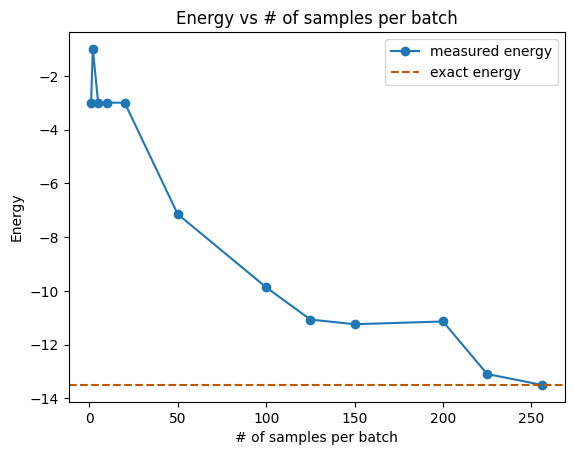

In [57]:
fig, ax = plt.subplots()
# Plot energies
ax.plot(samples_per_batch_list, eigvals_min_batch_list, label="measured energy", marker="o")
ax.set(xlabel='# of samples per batch', ylabel='Energy', title='Energy vs # of samples per batch')
ax.axhline(
    y=gs_energy,
    color="#BF5700",
    linestyle="--",
    label="exact energy",
)
ax.legend()

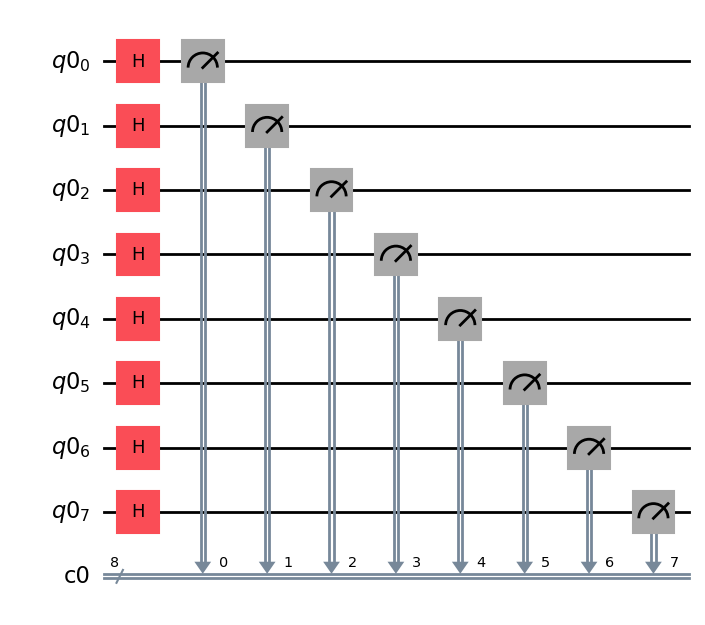

In [334]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile

qreg = QuantumRegister(n_qubits)
creg = ClassicalRegister(n_qubits)

circuit = QuantumCircuit(qreg, creg)
circuit.h(qreg)
circuit.measure(qreg, creg)

circuit.draw('mpl')

In [335]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as RuntimeSampler
from qiskit_ibm_runtime.accounts import AccountNotFoundError
from qiskit.visualization import plot_distribution

instance = 'ibm-q-utokyo/internal/icepp'  # For internal use

try:
    service = QiskitRuntimeService(channel='ibm_quantum', instance=instance)
except AccountNotFoundError:
    service = QiskitRuntimeService(channel='ibm_quantum', token='3d0089648866eac9a8491982fe2bf8bc133bcd4b2287893005c72a03fc08c0e15d62abf0096863701dea72237773b312f03678b89466d1b471191db4d5aaffa7', instance=instance)

# 最も空いているバックエンドを見つけて、そのバックエンドに対して回路をトランスパイル
backend = service.least_busy(min_num_qubits=n_qubits, simulator=False, operational=True)
print(f"least busy backend: {backend.name}")

circuit_transpiled = transpile(circuit, backend=backend)

/tmp/ipython-input-335-2646318743.py:10: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService(channel='ibm_quantum', token='3d0089648866eac9a8491982fe2bf8bc133bcd4b2287893005c72a03fc08c0e15d62abf0096863701dea72237773b312f03678b89466d1b471191db4d5aaffa7', instance=instance)


least busy backend: ibm_kingston


In [336]:
sampler = RuntimeSampler(backend)

shots = 10000

job = sampler.run([circuit_transpiled], shots=shots)
print(f">>> Job ID: {job.job_id()}, Status: {job.status()}")

/root/.local/lib/python3.11/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:1129: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


>>> Job ID: d1md3ddx3st0008yjr90, Status: QUEUED


In [338]:
#job = service.job("d1md3ddx3st0008yjr90")
print(f">>> Job Status: {job.status()}")

>>> Job Status: DONE


{'10101000': 45, '11101101': 40, '00110101': 32, '11001001': 27, '00001011': 42, '01101100': 46, '11101010': 46, '01101010': 41, '00101010': 42, '00111011': 45, '01000100': 34, '11110011': 41, '10111111': 45, '00110111': 36, '11001010': 37, '00100101': 37, '01010111': 35, '01000010': 38, '00110011': 38, '11011010': 35, '00111000': 40, '00101011': 54, '11100110': 45, '10010001': 34, '11111010': 44, '11110000': 42, '11100010': 44, '01000111': 45, '01010100': 36, '01111110': 34, '11000111': 42, '10100001': 41, '11101000': 44, '00101110': 42, '11111011': 37, '10000101': 32, '10000001': 27, '01101011': 34, '00100100': 53, '11011110': 43, '01011000': 35, '00011010': 46, '10001000': 40, '10100101': 40, '01000001': 43, '11011001': 34, '01110111': 36, '01111000': 37, '10010000': 25, '10010011': 49, '11100100': 38, '10101110': 40, '11000101': 52, '11000010': 35, '10110111': 42, '11010111': 31, '00010111': 45, '10000011': 38, '00101100': 30, '01101110': 38, '01010011': 35, '01010101': 43, '100001

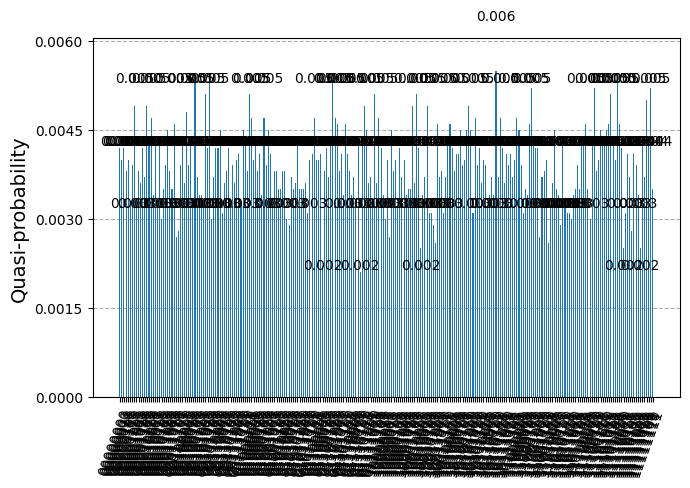

In [343]:
result = job.result()
print(result[0].data.c0.get_counts())
plot_distribution(result[0].data.c0.get_counts())

In [352]:
counts = result[0].data.c0.get_counts()

# ビット列からBool変数の行列を生成
bitstring_matrix_full, probs_array_full = counts_to_arrays(counts)

# バッチの数
n_batches = 10
# バッチあたりのサンプル数
samples_per_batch = 200

# ビット列から部分空間に対応するサブサンプルを生成
batches_tmp = subsample(
    bitstring_matrix_full,
    probs_array_full,
    samples_per_batch = samples_per_batch,
    num_batches = n_batches,
    rand_seed = rng
)

In [353]:
print("部分空間に射影されたハミルトニアンの基底エネルギー：")

eigvals_min_batch = []

for j in range(n_batches):
  # ビット列の重複がある場合、重複している行列要素を除く
  batches_removed = sort_and_remove_duplicates(np.array(batches_tmp)[j])
  #print(j,batches_removed)

  # ハミルトニアンをbatched_removedが貼るヒルベルト空間に射影
  #d, _ = batches_removed.shape
  projected_hamiltonian = project_operator_to_subspace(batches_removed, hamiltonian, verbose=False)
  #print(j,projected_hamiltonian)

  # 射影されたハミルトニアンを対角化
  eigenvals, eigenstates = eigsh(projected_hamiltonian.toarray())
  #print(f"  バッチ {j} - 固有値: {np.round(eigenvals, 6)}")
  print(f"  バッチ {j} : {np.round(np.min(eigenvals), 6)}")

  eigvals_min_batch.append(np.min(eigenvals))

print(f"->最低エネルギー {np.round(np.min(eigvals_min_batch), 6)}")

部分空間に射影されたハミルトニアンの基底エネルギー：
  バッチ 0 : -12.101039
  バッチ 1 : -11.375821
  バッチ 2 : -11.590702
  バッチ 3 : -11.735515
  バッチ 4 : -12.513678
  バッチ 5 : -11.972611
  バッチ 6 : -11.556897
  バッチ 7 : -10.916009
  バッチ 8 : -12.577813
  バッチ 9 : -11.953081
->最低エネルギー -12.577813


バッチ数に対する依存性のチェック

In [ ]:
n_batches_list = [10, 50, 100, 200]

samples_per_batch = 10

batches_tmp_list = []
# ビット列から部分空間に対応するサブサンプルを生成
for i_batch in range(len(n_batches_list)):
  batches_tmp = subsample(
      bitstring_matrix_full,
      probs_array_full,
      samples_per_batch = samples_per_batch,
      num_batches = n_batches_list[i_batch],
      rand_seed = rng
  )
  batches_tmp_list.append(batches_tmp)

In [ ]:
eigvals_min_batch_list = []

for i_batch in range(len(n_batches_list)):

  for j in range(n_batches_list[i_batch]):
    # ビット列の重複がある場合、重複している行列要素を除く
    batches_removed = sort_and_remove_duplicates(np.array(batches_tmp_list[i_batch])[j])

    # ハミルトニアンをbatched_removedが貼るヒルベルト空間に射影
    projected_hamiltonian = project_operator_to_subspace(batches_removed, hamiltonian, verbose=False)

    # 射影されたハミルトニアンを対角化
    eigenvals, eigenstates = eigsh(projected_hamiltonian.toarray())
    #print(f"バッチ {j} : {np.round(np.min(eigenvals), 6)}")

  eigvals_min_batch_list.append(np.min(eigenvals))

  print(f"n_batches = {n_batches_list[i_batch]}, 最低エネルギー {np.round(np.min(eigenvals), 6)}")

In [ ]:
fig, ax = plt.subplots()
# Plot energies
ax.plot(n_batches_list, eigvals_min_batch_list, label="energy error", marker="o")
ax.set(xlabel='# of batches', ylabel='Minimum energy observed', title='Observed minimum energy vs # of batches')